In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn  
import torch.optim as optim  
import torchvision.transforms as transforms 
import torchvision
import os
from skimage import io
from torch.utils.data import (Dataset,DataLoader) 

In [ ]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_directory = '/content/drive/MyDrive/Colab Notebooks/SoftComputing Lab/Assignment2/training-c.csv'
df = pd.read_csv(main_directory, sep=",")
print(df)

         filename           original filename  ...  contributing team  database name
0      c00000.png  Scan_280_digit_6_num_7.png  ...   Buet_Backpropers     training-c
1      c00001.png   Scan_29_digit_1_num_1.png  ...   Buet_Backpropers     training-c
2      c00002.png  Scan_131_digit_3_num_1.png  ...   Buet_Backpropers     training-c
3      c00003.png  Scan_160_digit_2_num_2.png  ...   Buet_Backpropers     training-c
4      c00004.png  Scan_202_digit_7_num_0.png  ...   Buet_Backpropers     training-c
...           ...                         ...  ...                ...            ...
24293  c24293.png  Scan_167_digit_3_num_4.png  ...   Buet_Backpropers     training-c
24294  c24294.png  Scan_174_digit_2_num_8.png  ...   Buet_Backpropers     training-c
24295  c24295.png  Scan_152_digit_7_num_4.png  ...   Buet_Backpropers     training-c
24296  c24296.png  Scan_123_digit_2_num_2.png  ...   Buet_Backpropers     training-c
24297  c24297.png    Scan_2_digit_7_num_6.png  ...   Buet_Backpro

In [ ]:
df.columns

Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')

In [ ]:
df = df.drop(['original filename','scanid','database name original', 'contributing team','database name'], axis = 1)

In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/SoftComputing Lab/Assignment2/modified.csv',index = False)

In [ ]:
batch_size = 15
input_dim = 100*100 
output_dim = 10
learning_rate = 0.001 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class HandWrittenNumberRecognition(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [ ]:
transform_Img = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize(100),
                                    transforms.ToTensor()])

In [ ]:
dataset = HandWrittenNumberRecognition(
    csv_file="/content/drive/MyDrive/Colab Notebooks/SoftComputing Lab/Assignment2/modified.csv",
    root_dir="/content/drive/MyDrive/Root/training-c",
    transform=transform_Img
)

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [19438,4860])
print(len(train_dataset))
print(len(test_dataset))

19438
4860


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
      
        self.linear_1 = nn.Linear(input_size,350)
        self.tanh_1 = nn.Tanh()

        self.linear_2 = nn.Linear(350, 300)
        self.tanh_2   = nn.Tanh()

        self.linear_3 = nn.Linear(300, 250)
        self.tanh_3 =  nn.Tanh()

        self.linear_4 = nn.Linear(250, 200)
        self.tanh_4   =  nn.Tanh()

        self.linear_5 = nn.Linear(200, 150)
        self.tanh_5 =  nn.Tanh()

        self.linear_6 = nn.Linear(150, 100)
        self.tanh_6 =  nn.Tanh()

        self.linear_out = nn.Linear(100,num_classes)

    def forward(self, x):
       
        out  = self.linear_1(x)
        out =  self.tanh_1(out)
        
        out  = self.linear_2(out)
        out =  self.tanh_2(out)

        out  = self.linear_3(out)
        out =  self.tanh_3(out)

        out  = self.linear_4(out)
        out =  self.tanh_4(out)

        out  = self.linear_5(out)
        out =  self.tanh_5(out)

        out  = self.linear_6(out)
        out =  self.tanh_6(out)
        
        probas  = self.linear_out(out)
        return probas



model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.7)

In [ ]:
iter = 0
total_loss = []
iteration = []
correctly_classified_PerEpoch = []
accuracy_perEpoch = []
num_of_epoch = []
for epoch in range(30):
    print('Epoch: ',epoch+1)
    num_of_epoch.append(epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 100*100).to(device)

        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        print('Iteration no: ',iter)
        if iter % 1500 == 0:
            print('loss in iteration ',iter,'= ',loss.item())
            total_loss.append(loss.item())
            iteration.append(iter)

    correct = 0
    total = 0
    for images, labels in test_loader:
          
          images = images.view(-1,100*100).to(device)
          outputs = model(images)
 
          _, predicted = torch.max(outputs, 1)

          total += labels.size(0)
 
          if torch.cuda.is_available():
                correct += (predicted.cpu() == labels.cpu()).sum() 
          else:
                correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total
    accuracy_perEpoch.append(accuracy)
    correctly_classified_PerEpoch.append(correct.item())
    print('Total Data: {}.  CorrectlyPredicted: {}.'.format(total,correct))
    print('Accuracy in epoch ',epoch+1,'=',accuracy)

Streaming output truncated to the last 5000 lines.
Iteration no:  33895
Iteration no:  33896
Iteration no:  33897
Iteration no:  33898
Iteration no:  33899
Iteration no:  33900
Iteration no:  33901
Iteration no:  33902
Iteration no:  33903
Iteration no:  33904
Iteration no:  33905
Iteration no:  33906
Iteration no:  33907
Iteration no:  33908
Iteration no:  33909
Iteration no:  33910
Iteration no:  33911
Iteration no:  33912
Iteration no:  33913
Iteration no:  33914
Iteration no:  33915
Iteration no:  33916
Iteration no:  33917
Iteration no:  33918
Iteration no:  33919
Iteration no:  33920
Iteration no:  33921
Iteration no:  33922
Iteration no:  33923
Iteration no:  33924
Iteration no:  33925
Iteration no:  33926
Iteration no:  33927
Iteration no:  33928
Iteration no:  33929
Iteration no:  33930
Iteration no:  33931
Iteration no:  33932
Iteration no:  33933
Iteration no:  33934
Iteration no:  33935
Iteration no:  33936
Iteration no:  33937
Iteration no:  33938
Iteration no:  33939
Iter

In [ ]:
root_path = '/content/drive/MyDrive/Colab Notebooks/SoftComputing Lab/Assignment2/Experiment_02_04/ALLCOVERED'
save_model = True
 
if save_model is True:
    torch.save(model.state_dict(), root_path + '170104027_Exp2_4.pkl') 

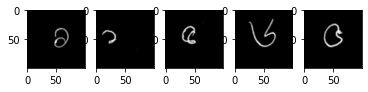

In [ ]:
import matplotlib
for images, labels in test_loader:
    break
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(images[i].view(100,100), cmap=matplotlib.cm.binary)

plt.show()

In [ ]:
for images, labels in test_loader:
    break
for i in range(1,6):
   predictions = model(images[i].view(-1, 100*100).to(device))
   predictions = torch.argmax(predictions, dim=1)
   print('Predicted labels', predictions.cpu().numpy())
   print(predictions)
   print(labels[i])

Predicted labels [2]
tensor([2], device='cuda:0')
tensor(1)
Predicted labels [4]
tensor([4], device='cuda:0')
tensor(5)
Predicted labels [0]
tensor([0], device='cuda:0')
tensor(6)
Predicted labels [0]
tensor([0], device='cuda:0')
tensor(5)
Predicted labels [7]
tensor([7], device='cuda:0')
tensor(3)


In [ ]:
print('loss count after every 750 iteration: ',total_loss)
print('iteration count: ',iteration)
print('Correctly classfied per epoch: ',correctly_classified_PerEpoch)
print('accuracy per epoch: ',accuracy_perEpoch)
print('Epoch list: ',num_of_epoch)

loss count after every 750 iteration:  [2.3004281520843506, 2.314870595932007, 2.3029775619506836, 2.2980973720550537, 2.292346477508545, 2.3047983646392822, 2.300706386566162, 2.3005969524383545, 2.307875156402588, 2.2900383472442627, 2.2679100036621094, 2.2912986278533936, 2.249060869216919, 2.0945897102355957, 2.110811948776245, 2.2258355617523193, 2.2403151988983154, 2.033323049545288, 2.03114652633667, 2.1056807041168213, 1.9533456563949585, 1.9570660591125488, 2.047799587249756, 2.0558838844299316, 1.935168743133545]
iteration count:  [1500, 3000, 4500, 6000, 7500, 9000, 10500, 12000, 13500, 15000, 16500, 18000, 19500, 21000, 22500, 24000, 25500, 27000, 28500, 30000, 31500, 33000, 34500, 36000, 37500]
Correctly classfied per epoch:  [483, 483, 456, 639, 511, 493, 689, 491, 504, 451, 527, 689, 760, 838, 836, 704, 900, 993, 1124, 1277, 1301, 1268, 924, 1062, 1435, 1488, 1152, 1269, 1446, 1028]
accuracy per epoch:  [9.938271604938272, 9.938271604938272, 9.382716049382717, 13.1481481

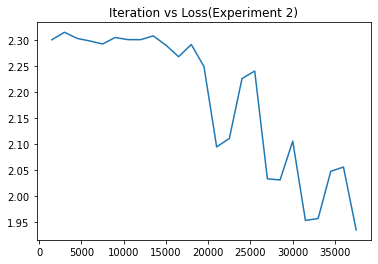

In [ ]:
plt.plot(iteration,total_loss)
plt.title('Iteration vs Loss(Experiment 2)')
plt.show()

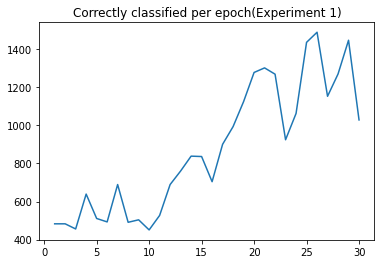

In [ ]:
plt.plot(num_of_epoch,correctly_classified_PerEpoch)
plt.title('Correctly classified per epoch(Experiment 1)')
plt.show()

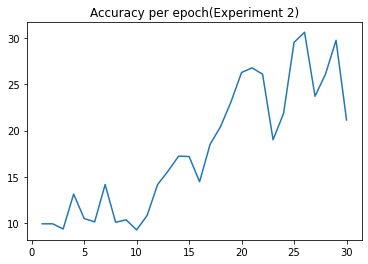

In [ ]:
plt.plot(num_of_epoch,accuracy_perEpoch)
plt.title('Accuracy per epoch(Experiment 2)')
plt.show()